Mounting the Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#defining the file path
animals_path = '/content/drive/MyDrive/animals.zip'

In [3]:
import zipfile
import os

# Destination folder for extraction
extract_path = '/content/animals_dataset'

# Unzip the file
with zipfile.ZipFile(animals_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")

Extraction complete!


In [4]:
# List the first few items in the extracted folder
print(os.listdir(extract_path))

['translate.py', 'raw-img']


In [5]:
raw_img_path = os.path.join(extract_path, 'raw-img')
print(os.listdir(raw_img_path))


['gallina', 'pecora', 'cavallo', 'cane', 'gatto', 'scoiattolo', 'ragno', 'elefante', 'farfalla', 'mucca']


In [6]:
# a quick dataset inspection tool, basically a way to peek into your dataset folders to confirm the structure and see some file samples.

# for folder in os.listdir(raw_img_path):
#     print(f"{folder}: {os.listdir(os.path.join(raw_img_path, folder))[:5]}")  #os.listdir(... )[:5] Lists the first 5 files in that folder


Class: gallina


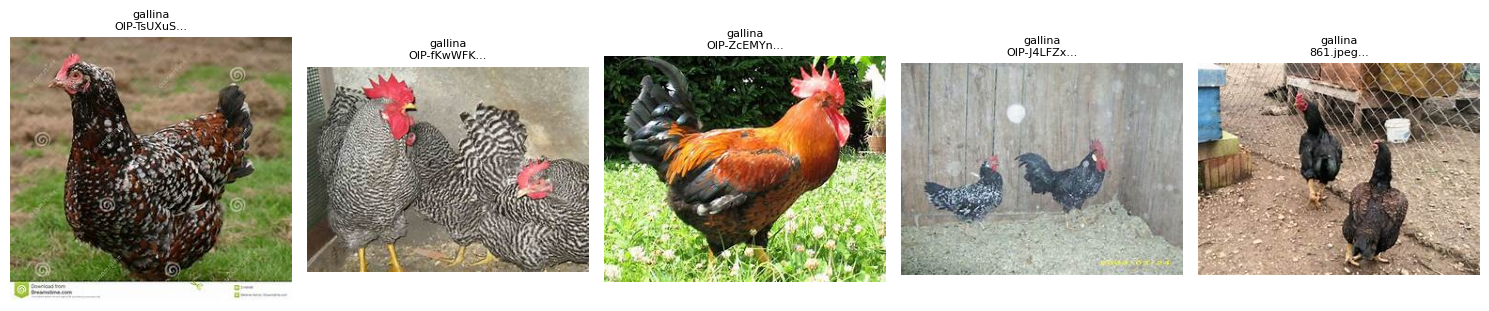


Class: pecora


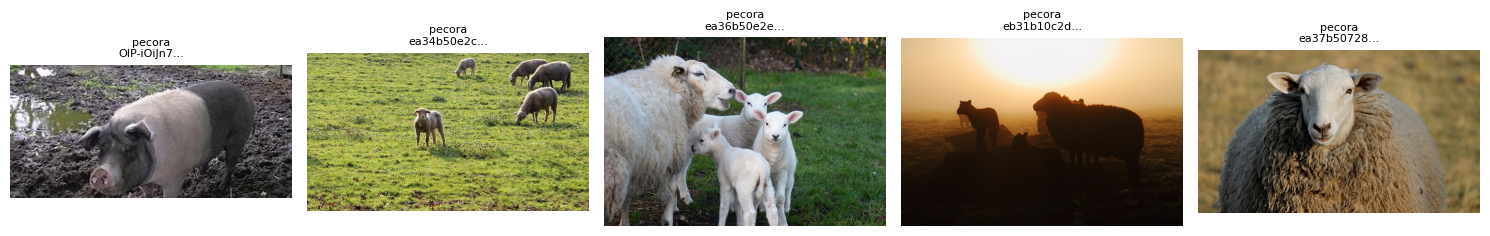


Class: cavallo


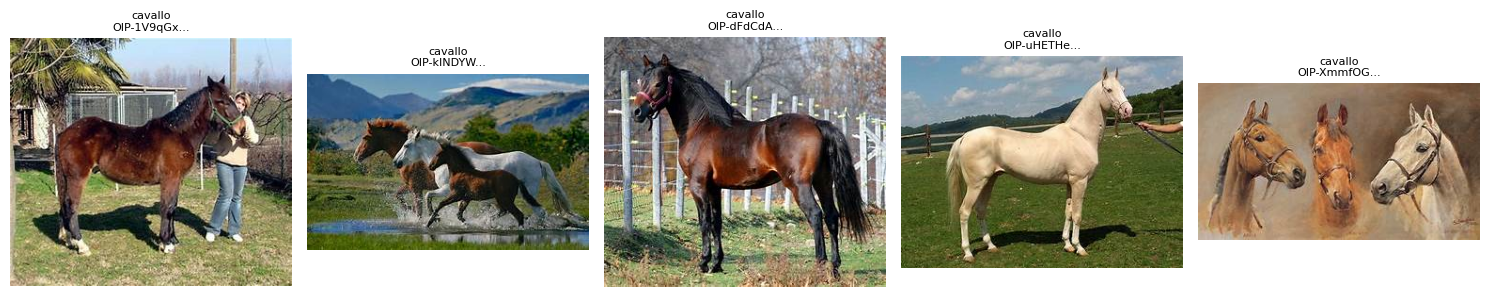


Class: cane


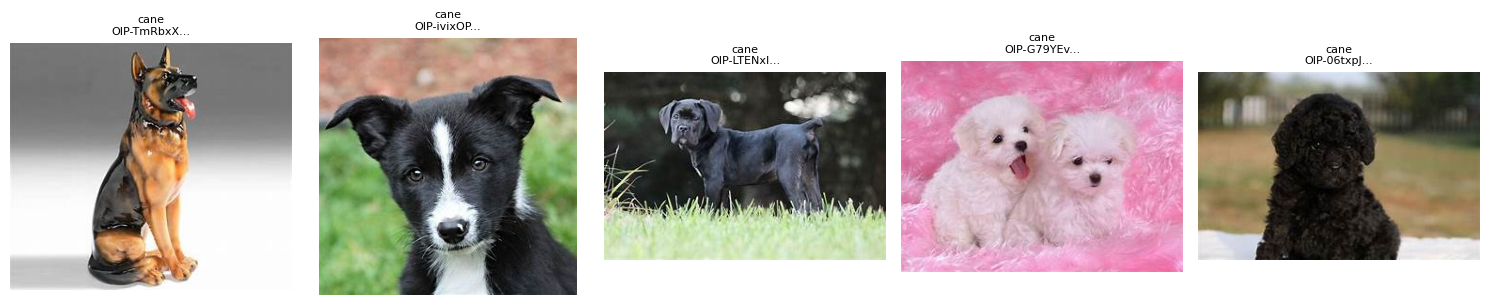


Class: gatto


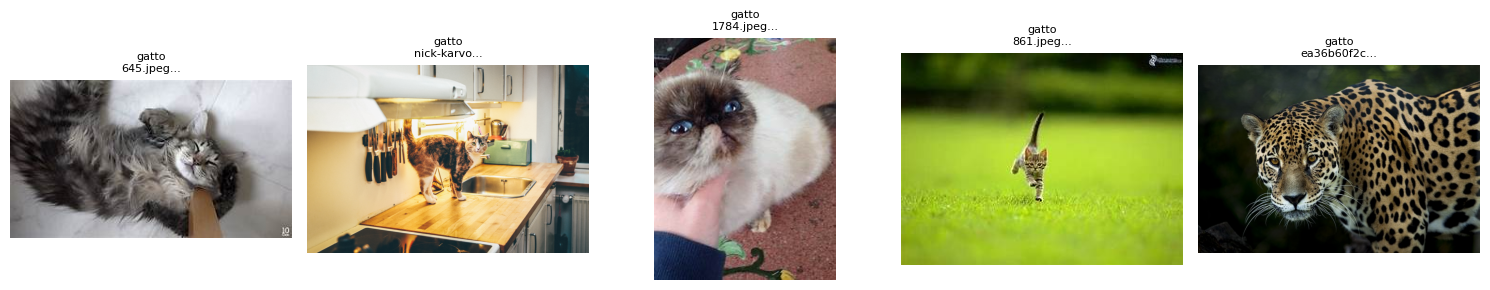


Class: scoiattolo


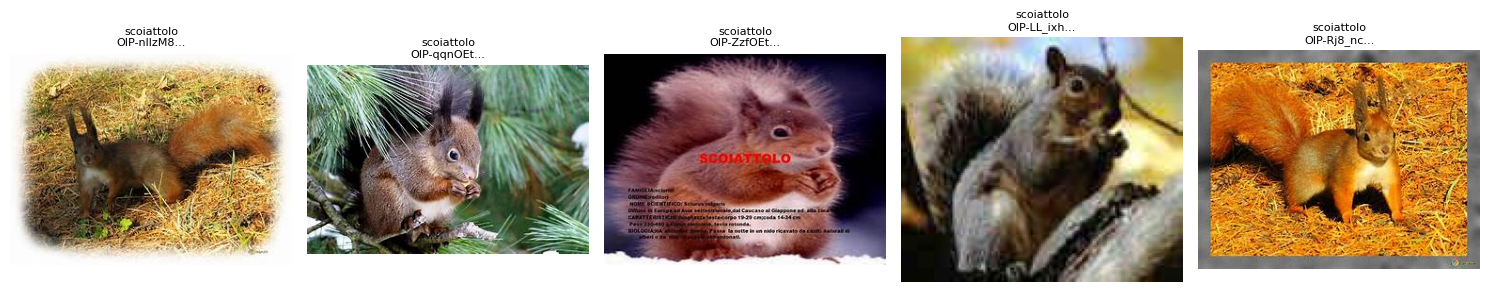


Class: ragno


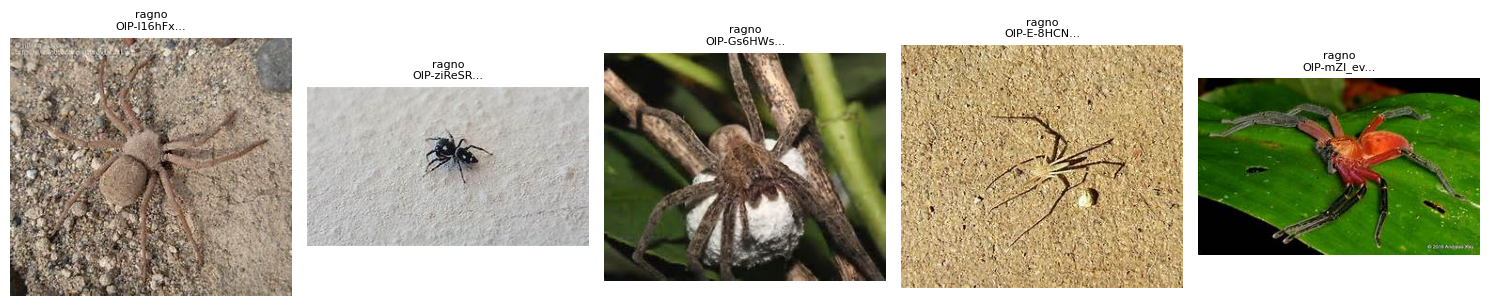


Class: elefante


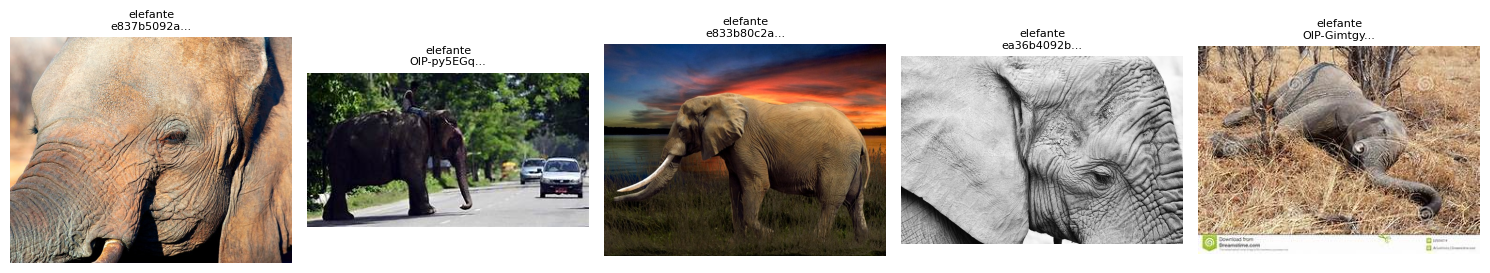


Class: farfalla


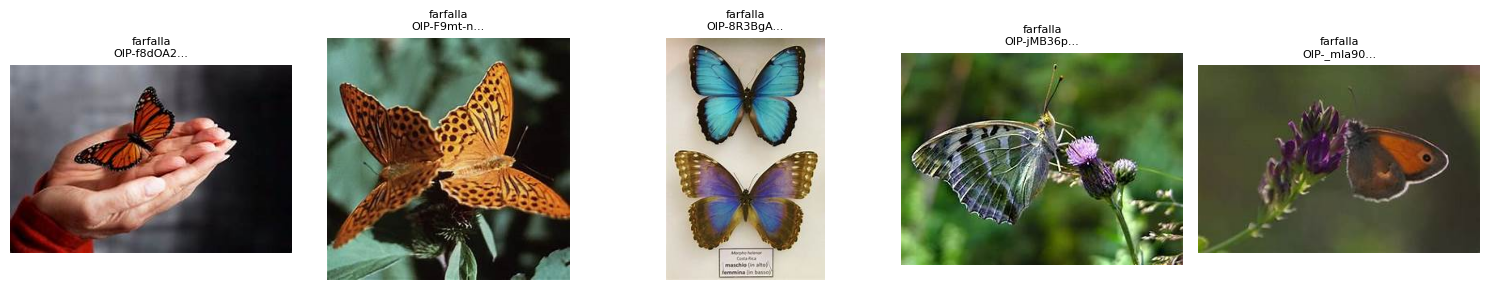


Class: mucca


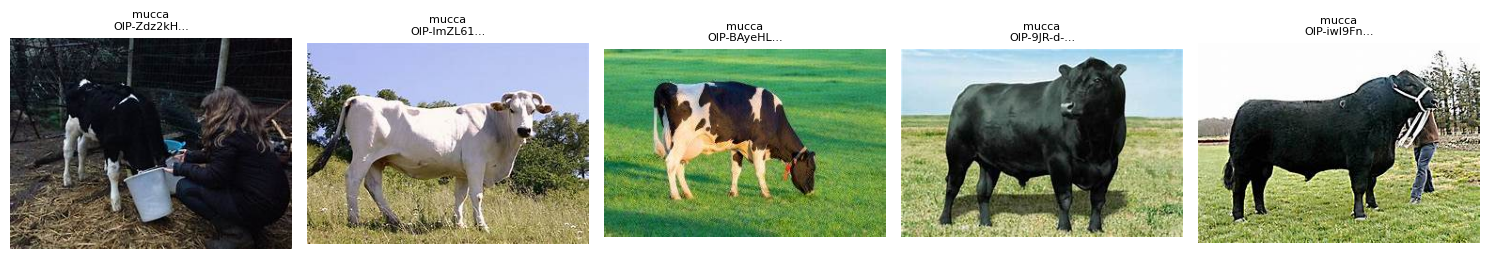

In [7]:
# Visualising the last 5 images from each class

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

raw_img_path = '/content/animals_dataset/raw-img/'

for folder in os.listdir(raw_img_path):
    folder_path = os.path.join(raw_img_path, folder)

    # Get first 5 images in the folder
    image_files = os.listdir(folder_path)[:5]
    print(f"\nClass: {folder}")

    # Create a subplot for the 5 images
    plt.figure(figsize=(15, 3))
    for idx, image_file in enumerate(image_files):
        img_path = os.path.join(folder_path, image_file)

        # Load and plot the image
        img = mpimg.imread(img_path)
        plt.subplot(1, 5, idx + 1)
        plt.imshow(img)
        plt.title(f"{folder}\n{image_file[:10]}...", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [9]:
#Preprocessing trainig/validation datasets
#spliting the dataset into training and validation sets, resizes all images, batch them, label them, and return them in a format ready for model training.

import tensorflow as tf

batch_size = 32
img_height = 224
img_width = 224

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    raw_img_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    raw_img_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


In [10]:
# Access class names
class_names = train_dataset.class_names
print("Classes:", class_names)

Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


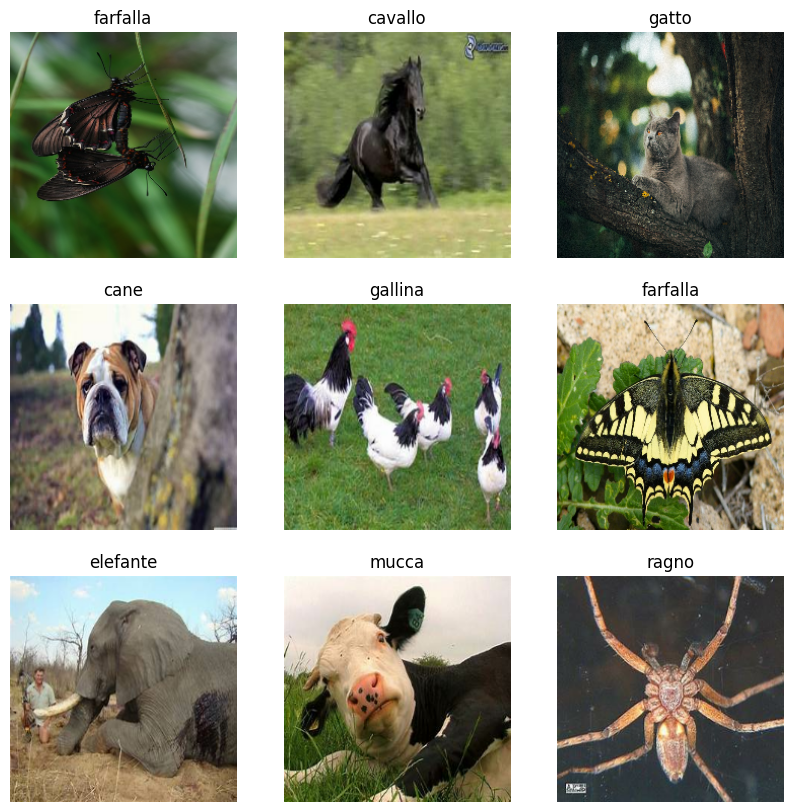

In [11]:
#visualize sample images from the training dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


In [12]:
# Optimize performance so your MobileNetV2 (or any model) trains faster.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.prefetch(buffer_size=AUTOTUNE)

------>---- Building MobileNet (Transfer learning model - 1) -----<-----

In [13]:
#importing required libraries

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import itertools

In [14]:
# data augmentation is a small Sequential model that applies random transformations to your training images on the fly during training.
#Prevents overfitting
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),], name="data_augmentation")


# Converts pixel values from [0, 255] to [-1, 1]. Matches exactly how MobileNetV2 was trained on ImageNet.
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


# Freeze base model initially
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet')


#freeze all the weights of your pretrained MobileNetV2 so they won’t be updated during the first training phase.
base_model.trainable = False


# Now building the full model
mn_model = tf.keras.Sequential([
    data_augmentation,
    # layers.Rescaling(1./127.5, offset=-1),  # must match MobileNetV2 preprocessing
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

In [15]:
# Compile the Model

mn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

mn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train the MobileNet Model

from tensorflow.keras.callbacks import EarlyStopping

# Step early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

EPOCHS = 10

history = mn_model.fit(train_ds,
                       validation_data=val_ds,
                       epochs= EPOCHS,

                       callbacks=[early_stop])



Epoch 1/10


------------>----- Fine tuning MobileNetV2 -----<----------------

In [ ]:
base_model.trainable = True

# Freeze bottom layers, fine-tune top
for layer in base_model.layers[:-50]:  # Unfreeze last 50 layers
    layer.trainable = False

# Compile with smaller learning rate
mn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune more
fine_tune_history = mn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])

In [ ]:
# import time

# # Define helper function if not defined yet
# def timed_training(model, train_data, val_data, epochs, initial_epoch=0):
#     start = time.time()
#     history = model.fit(train_data, validation_data=val_data,
#                         epochs=epochs, initial_epoch=initial_epoch)
#     end = time.time()
#     print(f"Training time for epochs {initial_epoch} to {epochs}: {(end - start)/60:.2f} minutes")
#     return history

# # Unfreeze the last N layers of the base model
# base_model.trainable = True

# # Freeze all layers except the last 50 (tweak as needed)
# for layer in base_model.layers[:-50]:
#     layer.trainable = False

# # Recompile with a lower learning rate for fine-tuning
# mn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# # Continue training (fine-tuning) with timing
# fine_tune_epochs = 10
# total_epochs = EPOCHS + fine_tune_epochs

# history_fine = timed_training(mn_model, train_ds, val_ds, total_epochs, initial_epoch=history.epoch[-1])

In [ ]:
# 5. Plot Accuracy and Loss -------------------------------------------------

# Combine history from both training phases
acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

# Adjust epochs range to reflect total epochs
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Evaluate Model on Validation or Test Set

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
y_pred_probs = mn_model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)
# y_true = np.argmax(y_true, axis=1)  # Remove this line

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Get model predictions
y_pred_probs = mn_model.predict(val_ds)                          # shape: (num_samples, num_classes)
y_pred = np.argmax(y_pred_probs, axis=1)                         # predicted class indices

# Get true labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)          # one-hot encoded or integer labels
if y_true.ndim == 2:
    y_true = np.argmax(y_true, axis=1)                           # convert one-hot to class index

# Print overall metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro'
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy :  {accuracy:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall   :  {recall:.4f}")
print(f"F1-score :  {f1:.4f}")

# Optional: Full classification report per class
from sklearn.metrics import classification_report
print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
